In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
from bin import utils

In [2]:
# fdata = sc.read_h5ad("./RNA/spatial.combined.clustered.h5")
fdata = sc.read_h5ad("/home/wpy/stereoseq/20240702-Exclusive/RNA/reclustered.h5")
fdata = fdata[:, ~fdata.var_names.str.startswith('sg')].copy()

gdata = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.filtered.guide.bin100.h5')

fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

fdata, gdata = utils.align_rna_guide_data(fdata, gdata)

gdata = utils.combine_guide_replicates(gdata)

guide_data = gdata.copy()
guide_data.obs['cluster'] = fdata.obs.cluster

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [3]:
# mdata = gdata[gdata.obs.marker == 'B926-1']
mdata = guide_data[guide_data.obs.marker == 'A']
# mdata.obs['cluster'] = fdata.obs.cluster_cellcharter_givenk.tolist()
c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
c_df = c_df.groupby(['cluster']).sum().unstack().unstack()

g_df = c_df.apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1)
g_df.head()

/tmp/ipykernel_2851/1787783747.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby(['cluster']).sum().unstack().unstack()


cluster,0,2,3,4,6
sgAckr3,10.960359,2.435635,15.019752,10.960359,16.034600
sgBatf,7.749237,1.937309,11.866020,8.475728,13.561166
sgBcl2,6.571440,1.577146,12.091450,9.462874,9.725732
sgBcl2l11,8.903367,3.257329,13.463628,9.771988,11.509230
sgBhlhe40,0.861299,0.861299,2.583898,1.722598,0.861299


/tmp/ipykernel_2851/617685960.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby(['cluster']).sum().unstack().unstack()
100%|██████████| 1000/1000 [00:21<00:00, 45.56it/s]


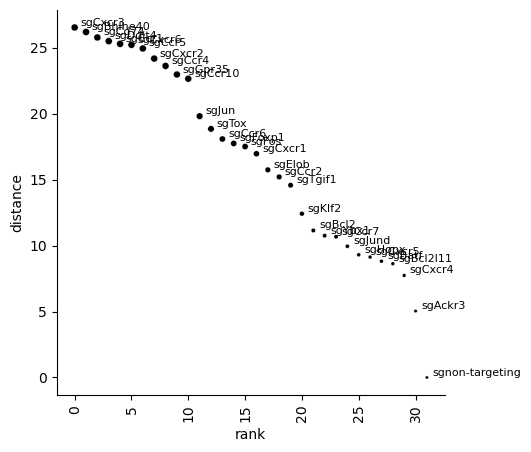

In [29]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import fdrcorrection

# mdata = gdata[gdata.obs.marker == 'B926-1']
mdata = guide_data[guide_data.obs.marker == 'A']
# mdata = guide_data
# mdata.obs['cluster'] = fdata.obs.cluster_cellcharter_givenk.tolist()
c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
c_df = c_df.groupby(['cluster']).sum().unstack().unstack()

eps = 1

index = c_df.index
p_values = np.zeros(len(c_df.index))
g_df = c_df.apply(lambda x: 10 ** (np.log10(x + eps) - (np.log10(x + eps).sum() / 12)), axis=1)
dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values

for i in tqdm(range(1000)):
    for i in range(len(c_df.index)):
        if c_df.index[i] == 'sgnon-targeting': continue
        values = c_df.iloc[i].tolist() + c_df.loc['sgnon-targeting'].tolist()
        np.random.shuffle(values)
        c_df.iloc[i] = values[:5]
    g_df = c_df.apply(lambda x: 10 ** (np.log10(x + eps) - (np.log10(x + eps).sum() / 12)), axis=1)
    dist_permute = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
    df = pd.DataFrame({'distance': dist, 'distance_permute': dist_permute})

    p_values += (np.array(df['distance'].tolist()) > np.array(df['distance_permute'].tolist()))
    # df['dist_rank'] = df['distance'].rank(method='min')
    # df['dist_permute_rank'] = df['distance_permute'].rank(method='min')
    # p_values += (np.array(df['dist_rank'].tolist()) > np.array(df['dist_permute_rank'].tolist()))
p_values = p_values / 1000
p_values

# p_values = {}
# for i in range(len(c_df.index)):
#     if c_df.index[i] == 'sgnon-targeting': continue
#     p_values[c_df.index[i]] = 0
# for i in range(100):
#     for i in range(len(c_df.index)):
#         if c_df.index[i] == 'sgnon-targeting': continue
#         guide_val = np.array(c_df.iloc[i].tolist())
#         ntc_val = np.array(c_df.loc['sgnon-targeting'].tolist())
#         for j in range(len(guide_val)):
#             if np.random.random() < 0.5:
#                 guide_val[j], ntc_val[j] = ntc_val[j], guide_val[j]
#         guide_val = 10 ** (np.log10(guide_val + 1) - np.log10(guide_val + 1).sum() / 5)
#         ntc_val = 10 ** (np.log10(ntc_val + 1) - np.log10(ntc_val+ 1).sum() / 5)
#         p_values[c_df.index[i]] += (euclidean(guide_val, ntc_val))
# dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
plot_df = pd.DataFrame({
    'distance': dist,
    'size': (p_values) * 20 + 5
}, index=index).sort_values(by='distance', ascending=False)
plot_df['rank'] = np.arange(0, len(plot_df))

plot_df

plt.figure(figsize=(5, 5))
sns.scatterplot(x=plot_df['rank'], y=plot_df['distance'], s=plot_df['size'], color='black')
for i, row in plot_df.iterrows():
    # if row['rank'] < 19:
        plt.text(row['rank'] + 0.5, row['distance'], i, fontsize=8, alpha=1, ha='left', va='bottom', rotation=0)
plt.xticks(rotation=90)
sns.despine()
# plt.show()

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./plots/Aitchison_guide_A_exclusive.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [43]:
plot_df['p_adj'] = (plot_df['size'] - 5) / 50
plot_df = plot_df.loc[plot_df.index != 'sgnon-targeting', :]
plot_df['p_adj'] = plot_df['p_adj'][::-1].tolist()
plot_df.to_csv('Aitchison_guide_A_exclusive.csv')

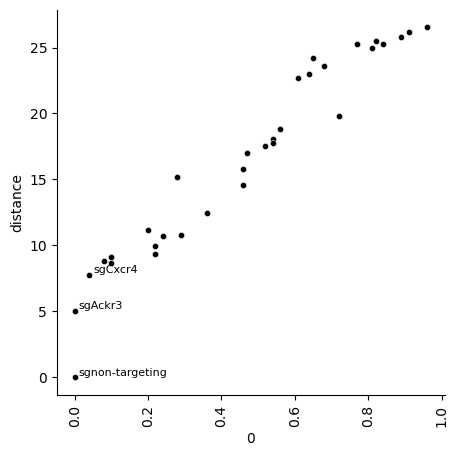

In [5]:
p_df = pd.DataFrame(p_values, index=c_df.index)
plot_df = pd.DataFrame(dist, index=g_df.index, columns=['distance']).sort_values(by='distance', ascending=False)
plot_df = pd.concat([plot_df, p_df], axis=1)

plt.figure(figsize=(5, 5))
sns.scatterplot(x=plot_df[0], y=plot_df['distance'], color='black', s=20)
for i, row in plot_df.iterrows():
    if row[0] < 0.05:
        plt.text(row[0] + 0.01, row['distance'], i, fontsize=8, alpha=1, ha='left', va='bottom', rotation=0)
plt.xticks(rotation=90)
sns.despine()
# plt.show()

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240702-Exclusive/plots/Aitchison_guide_A_exclusive_p.pdf', bbox_inches='tight', format='pdf')
plt.show()

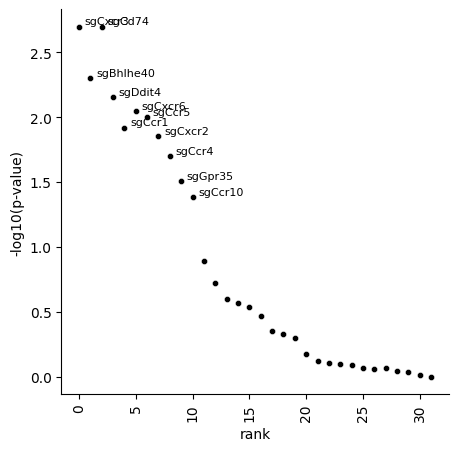

In [25]:
p_df = pd.DataFrame(p_values, index=c_df.index)
plot_df = pd.DataFrame(dist, index=g_df.index, columns=['distance']).sort_values(by='distance', ascending=False)
plot_df = pd.concat([plot_df, p_df], axis=1)
plot_df['rank'] = np.arange(0, len(plot_df))
plot_df.loc['sgnon-targeting', 0] = 1
plot_df['-log10(p-value)'] = -np.log10(plot_df[0])

plt.figure(figsize=(5, 5))
sns.scatterplot(x=plot_df['rank'], y=plot_df['-log10(p-value)'], color='black', s=20)
for i, row in plot_df.iterrows():
    if row[0] < 0.05:
        plt.text(row['rank'] + 0.5, row['-log10(p-value)'], i, fontsize=8, alpha=1, ha='left', va='bottom', rotation=0)
plt.xticks(rotation=90)
sns.despine()
# plt.show()

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240702-Exclusive/plots/Aitchison_guide_A_exclusive_p.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [6]:
c_df = pd.DataFrame(guide_data.X, columns=guide_data.var_names)
c_df["marker"] = guide_data.obs["marker"].tolist()
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

from scipy.stats import chi2_contingency
m_df = c_df.loc['A'].unstack()
ntc_cnt = m_df.loc['sgnon-targeting'].sum()
m_df = m_df.div(m_df.sum(axis=1), axis=0) * ntc_cnt
chi_dict = {}
for guide in gdata.var_names:
    if m_df.loc[guide].sum() == 0:
        chi_dict[guide] = 1
        continue
    if guide == 'sgnon-targeting': continue
    chi_dict[guide] = chi2_contingency(m_df.loc[['sgnon-targeting', guide]].T).statistic

/tmp/ipykernel_12406/4109014694.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')


Text(0.5, 0, 'Guide')

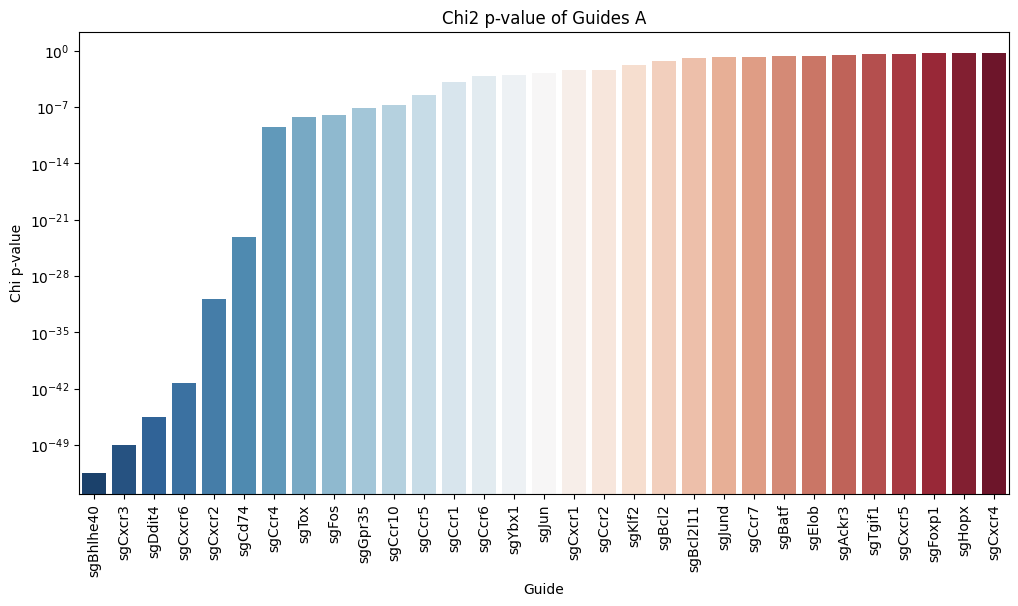

In [19]:
pdf = pd.DataFrame(chi_dict, index=['Chi p-value']).T.sort_values(by='Chi p-value').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')
plt.xticks(rotation=90)
plt.gca().set_yscale('log')
plt.title('Chi2 p-value of Guides A')
plt.xlabel('Guide')

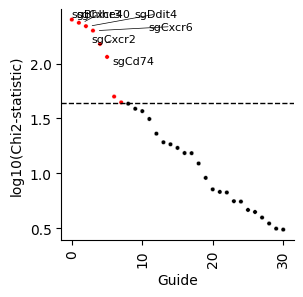

In [18]:
import seaborn as sns

p_df = pd.DataFrame(chi_dict.values(), index=chi_dict.keys())
p_df.sort_values(by=0, ascending=False, inplace=True)
p_df = p_df[p_df.index != 'sgPomt1']
p_df['log10(p-value)'] = np.log10(p_df[0])
p_df['rank'] = np.arange(0, len(p_df))
p_df['sig'] = p_df['rank'].map(lambda x: 'yes' if x <= np.quantile(p_df['rank'], 0.25) else 'no')

plt.figure(figsize=(3, 3))
sns.scatterplot(x='rank', y='log10(p-value)', data=p_df, color='black', s=10, hue='sig', palette=['red', 'black'], legend=False)
plt.axhline(y=p_df['log10(p-value)'].quantile(0.75), color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
texts = []
for i, row in p_df.iterrows():
    if row['log10(p-value)'] > 1.8:
        texts.append(plt.text(row['rank'] + 0.5, row['log10(p-value)'], i, fontsize=8, alpha=1, ha='left', va='bottom', rotation=0))
import adjustText as aT
aT.adjust_text(texts=texts, expand_points=(1.5, 1.5), expand_text=(1.5, 1.5), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
plt.xlabel('Guide')
plt.xticks(rotation=90)
plt.ylabel('log10(Chi2-statistic)')
sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/chi2_guide_A_exclusive.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [38]:
from scipy.stats import chi2_contingency
m_df = c_df.loc['B'].unstack()
ntc_cnt = m_df.loc['sgnon-targeting'].sum()
m_df = m_df.div(m_df.sum(axis=1), axis=0) * ntc_cnt
chi_dict = {}
for guide in gdata.var_names:
    if m_df.loc[guide].sum() == 0:
        chi_dict[guide] = 1
        continue
    if guide == 'sgnon-targeting': continue
    g_df = m_df.loc[['sgnon-targeting', guide]].T
    g_df = g_df[g_df.sum(axis=1) > 0]
    chi_dict[guide] = chi2_contingency(g_df).pvalue

/tmp/ipykernel_39116/2463507377.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')


Text(0.5, 0, 'Guide')

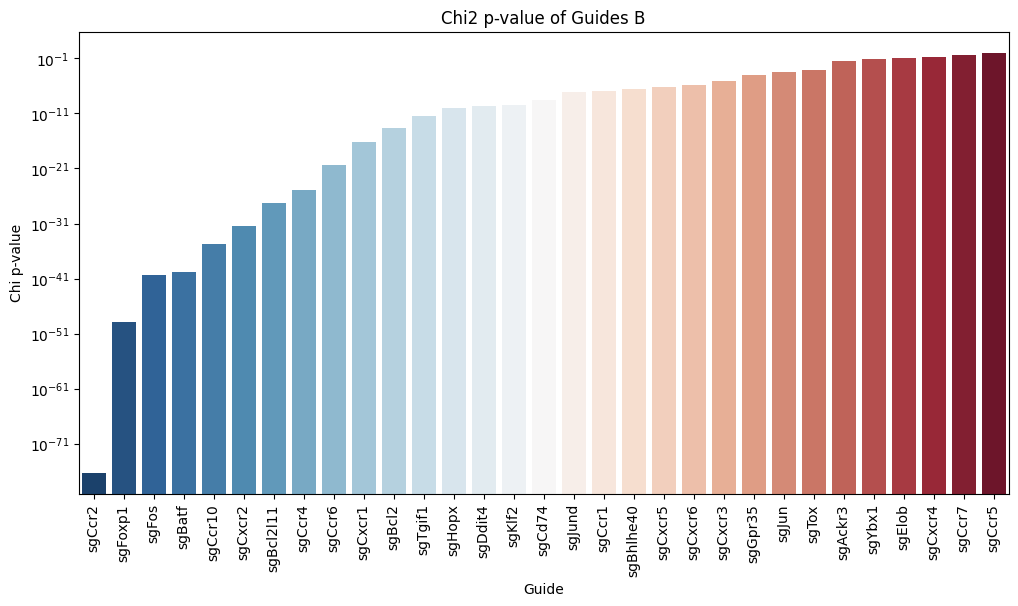

In [40]:
pdf = pd.DataFrame(chi_dict, index=['Chi p-value']).T.sort_values(by='Chi p-value').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(pdf, x='index', y='Chi p-value', palette='RdBu_r')
plt.xticks(rotation=90)
plt.gca().set_yscale('log')
plt.title('Chi2 p-value of Guides B')
plt.xlabel('Guide')

# Specific

In [8]:
df = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names), fdata.obs.cluster], axis=1)

In [9]:
c_df = df.groupby("cluster").sum()

/tmp/ipykernel_73714/467020417.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = df.groupby("cluster").sum()


In [10]:
p_df = c_df / c_df.sum(axis=0)

<Figure size 1000x1000 with 0 Axes>

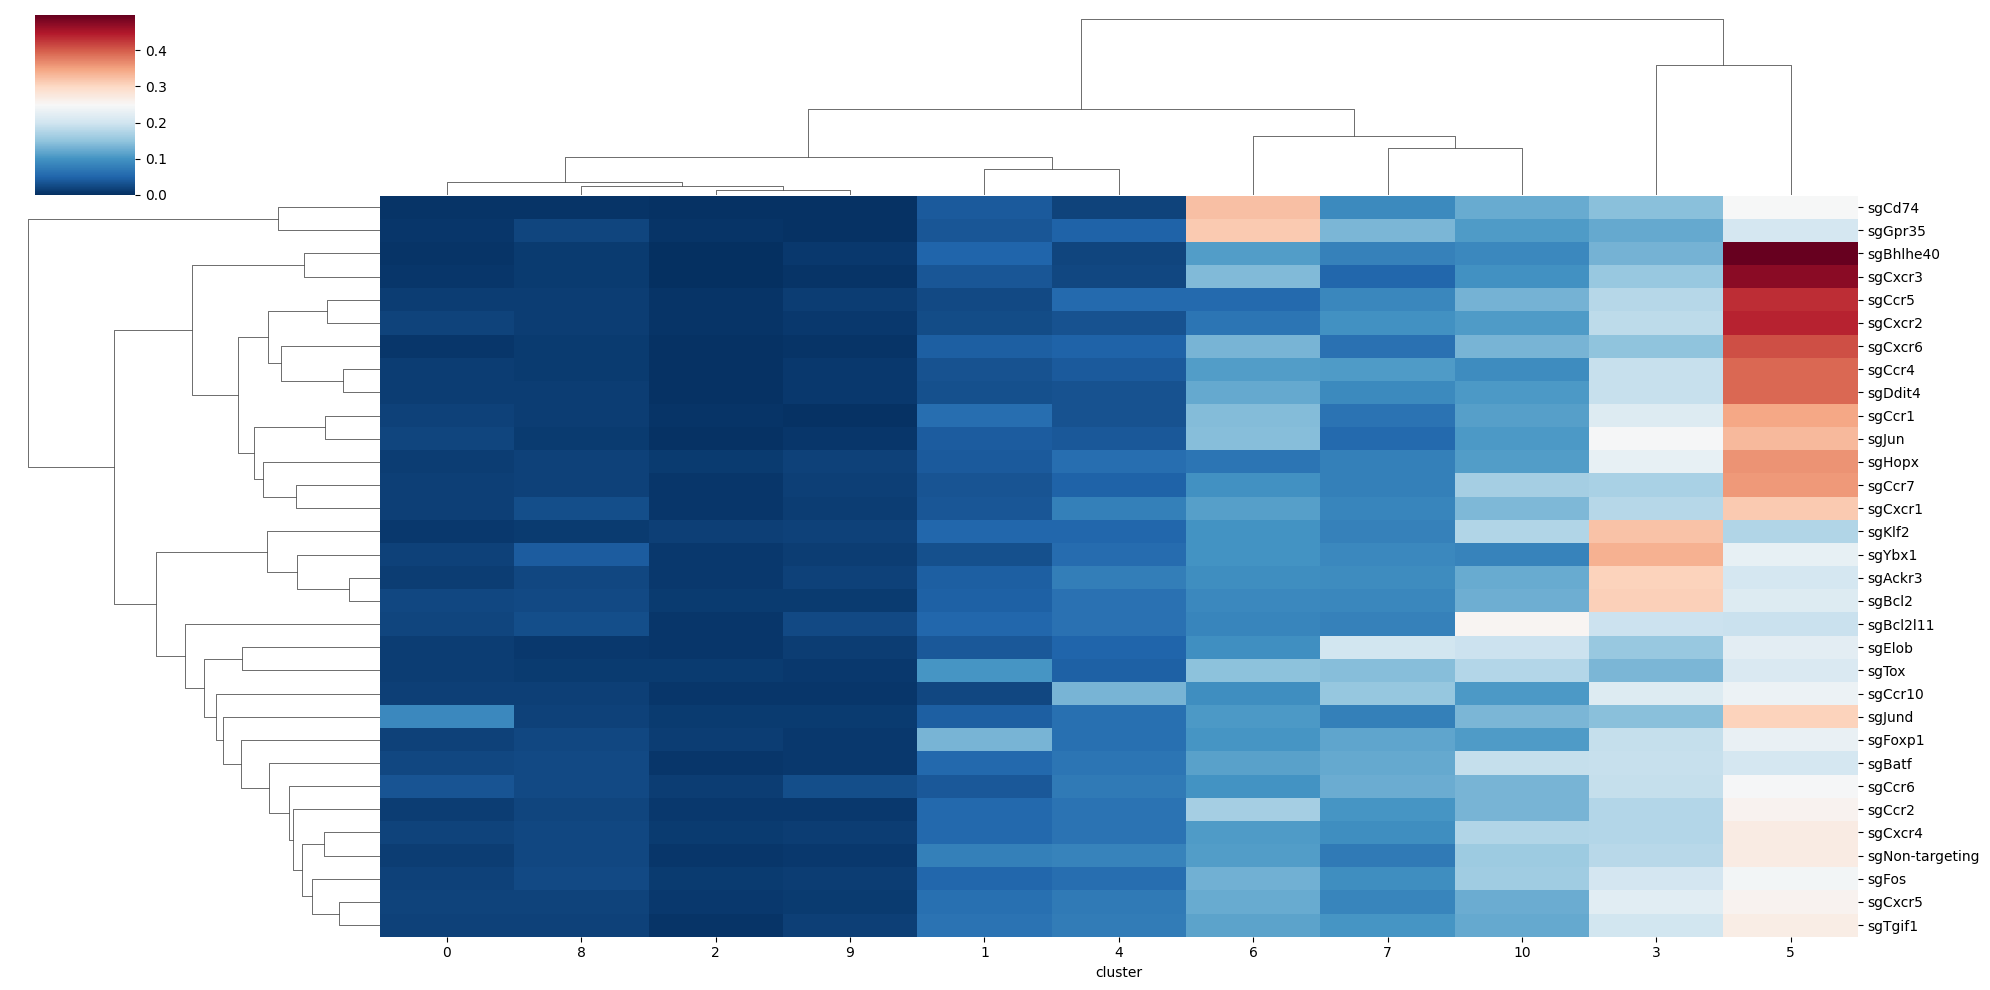

In [11]:
plt.figure(figsize=(10, 10))
sns.clustermap(p_df.T, cmap='RdBu_r', figsize=(20, 10))
plt.show()

<Figure size 1000x1000 with 0 Axes>

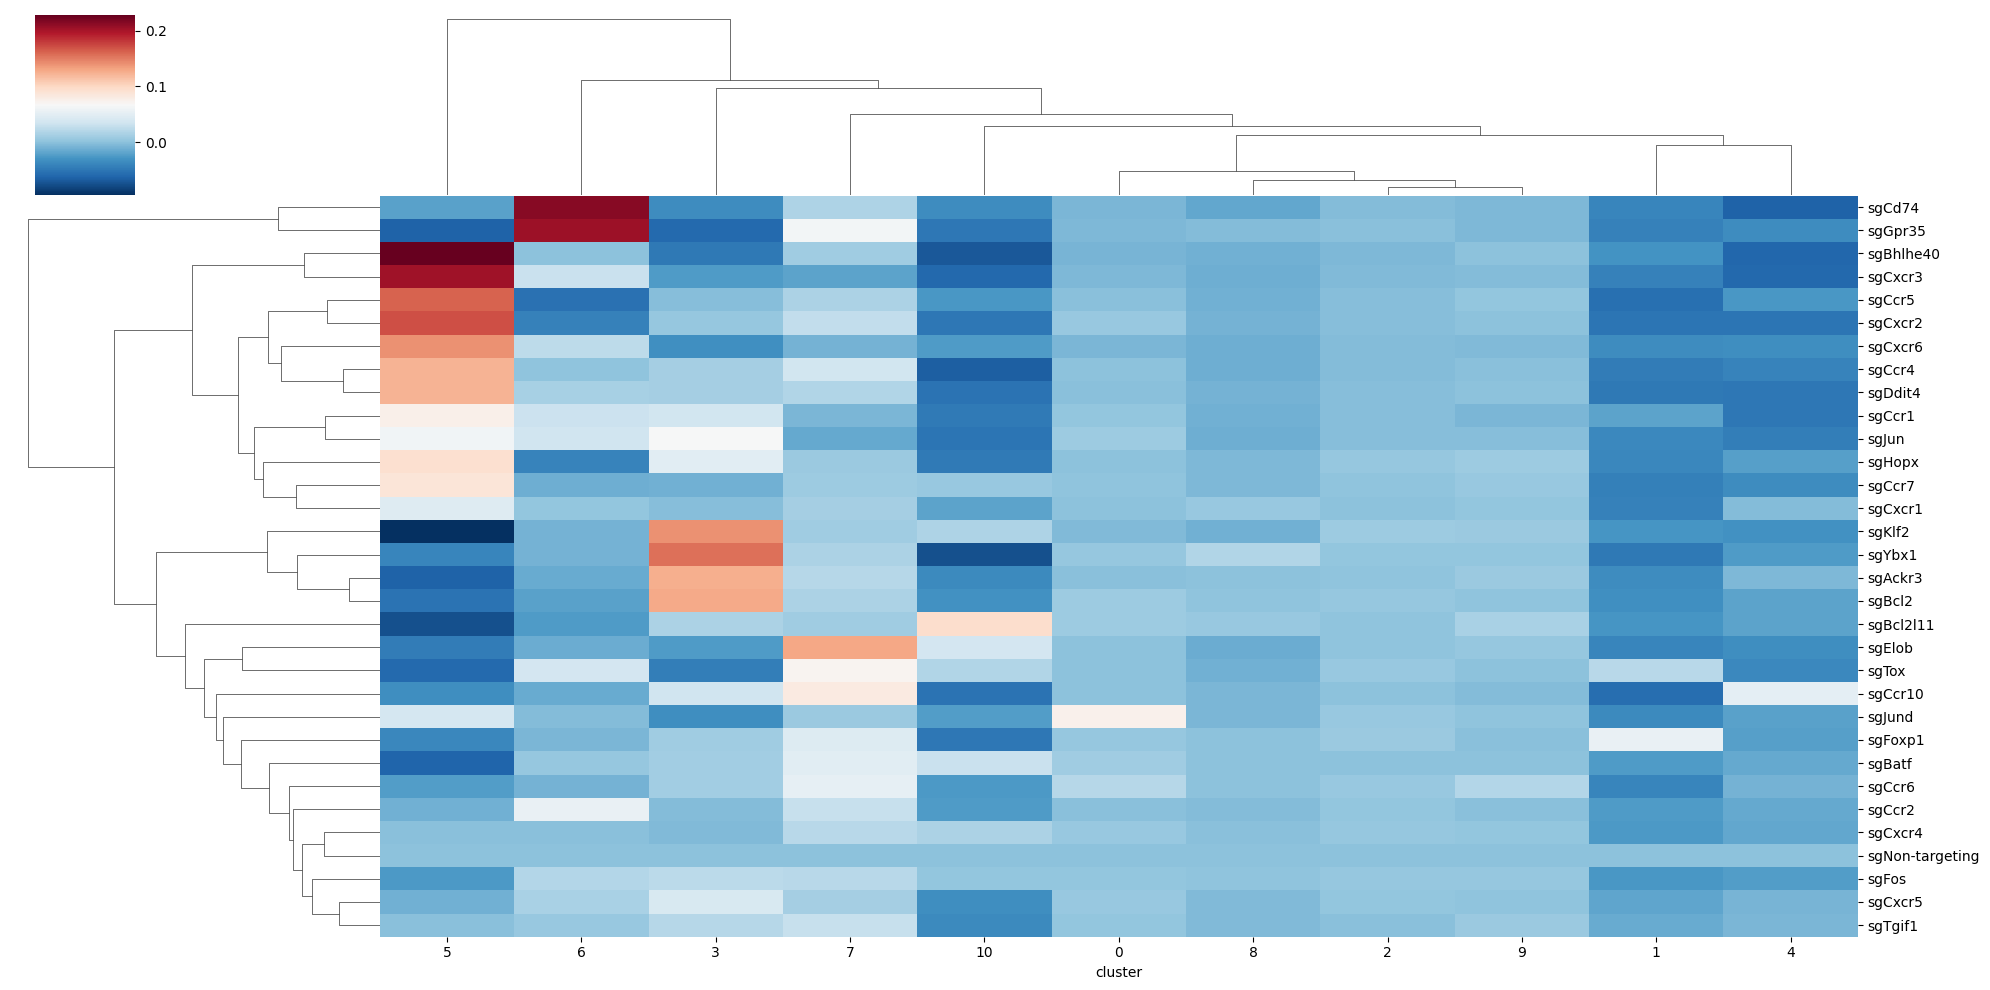

In [12]:
plt.figure(figsize=(10, 10))
sns.clustermap(p_df.T - p_df["sgNon-targeting"], cmap='RdBu_r', figsize=(20, 10))
plt.show()

In [13]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
guide_corr_matrix = np.zeros((len(p_df.columns), len(p_df.columns)))
for i, guide in enumerate(p_df.columns):
    for j, guide_x in enumerate(p_df.columns):
        guide_corr_matrix[i, j] = pearsonr(p_df[guide], p_df[guide_x])[0]

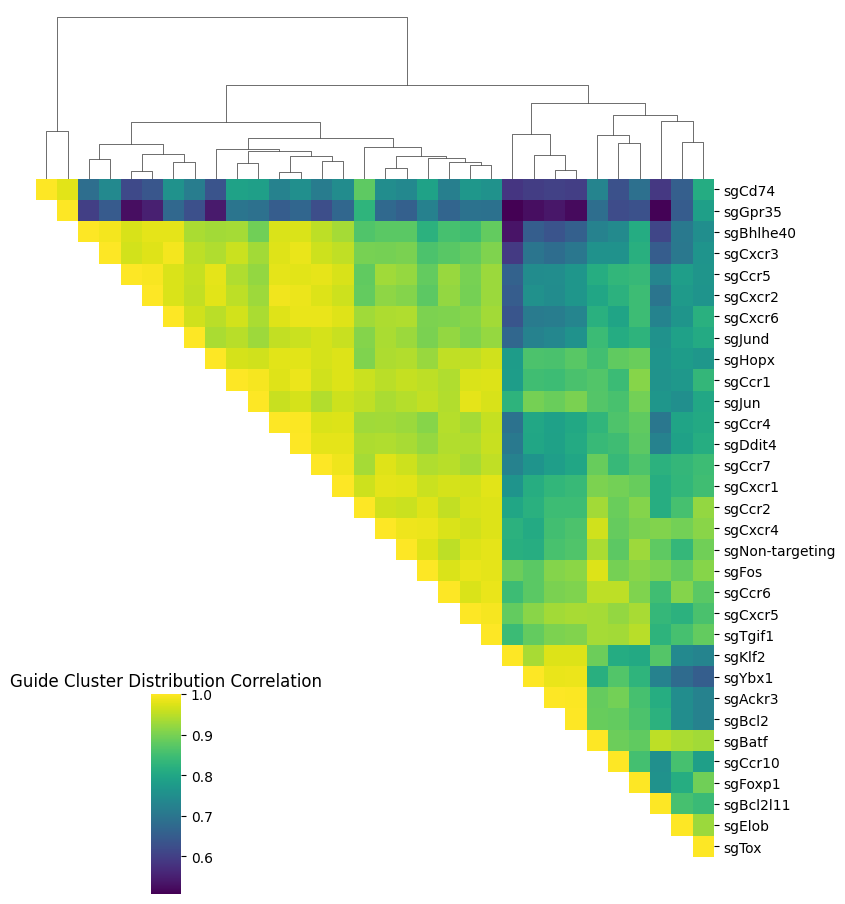

In [14]:
guide_corr_df = pd.DataFrame(guide_corr_matrix, columns=p_df.columns, index=p_df.columns)

# 使用 seaborn 的 clustermap 绘制热图，并只对 x 轴进行聚类
g = sns.clustermap(guide_corr_df, cmap='viridis', figsize=(10, 10), col_cluster=True, row_cluster=True)

# 只显示右上角部分的矩阵，并保留颜色条
g.ax_row_dendrogram.set_visible(False)

# 获取聚类后的索引顺序
clustered_index = g.dendrogram_row.reordered_ind
clustered_columns = g.dendrogram_col.reordered_ind

# 创建一个新的掩码，只显示右上角部分
mask = np.zeros_like(guide_corr_df, dtype=bool)
mask[np.tril_indices_from(mask, -1)] = True

for i in range(len(mask)):
    for j in range(len(mask)):
        if mask[clustered_index[i], clustered_columns[j]]:
            g.ax_heatmap.add_patch(plt.Rectangle((clustered_columns[j], clustered_index[i]), 1, 1, fill=True, color='white', lw=0))

g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.xaxis.set_label_position('top')

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks(np.arange(len(guide_corr_df.index)) + 0.5)
g.ax_heatmap.set_yticklabels(guide_corr_df.index[clustered_index])

cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.3, 0.1, 0.03, 0.2])  # [left, bottom, width, height]

plt.title('Guide Cluster Distribution Correlation')

plt.show()

In [15]:
_, gdata = extract_guide_from_rna(cdata_bin100)
fdata, gdata = utils.align_rna_guide_data(fdata, gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:127: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs[marker_name], guidedata.obsm["spatial"])]


In [16]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [17]:
df = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names), fdata.obs.cluster], axis=1)
c_df = df.groupby("cluster").sum()
p_df = c_df / c_df.sum(axis=0)

/tmp/ipykernel_73714/1414938591.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = df.groupby("cluster").sum()


In [18]:
c_df

,sgAckr3,sgBatf,sgBcl2,sgBcl2l11,sgBhlhe40,sgCcr1,sgCcr10,sgCcr2,sgCcr4,sgCcr5,...,sgFoxp1,sgGpr35,sgHopx,sgJun,sgJund,sgKlf2,sgNon-targeting,sgTgif1,sgTox,sgYbx1
cluster,,,,,,,,,,,,,,,,,,,,,
0,16,38,30,35,2,8,9,12,5,3,...,18,6,27,17,121,11,54,15,8,14
1,57,92,65,86,22,29,15,52,12,6,...,144,31,83,33,59,63,325,59,63,24
2,10,12,14,12,0,2,4,8,1,1,...,13,4,22,3,16,18,25,5,7,7
3,392,327,431,333,58,107,140,169,71,45,...,204,103,476,199,201,399,741,184,84,272
4,98,114,87,106,9,16,87,63,15,14,...,65,40,124,30,84,63,339,69,28,46
5,263,353,301,329,221,171,153,247,145,109,...,247,174,753,266,423,216,1106,245,131,185
6,122,194,123,143,49,70,62,158,41,14,...,110,268,141,116,147,124,451,105,91,81
7,119,207,122,138,36,32,100,97,40,22,...,126,115,165,45,109,101,297,93,89,71
8,29,40,34,47,5,6,10,19,4,3,...,25,17,34,8,22,14,94,16,7,33


In [19]:
r_dict = {}
r_dict_ = {}
guide_genes = gdata.var_names.str.split('_').str.get(0).unique()
for guide in tqdm(guide_genes):
    if guide+"_1" in gdata.var_names and guide+"_2" in gdata.var_names:
        r_dict[guide] = spearmanr(p_df[guide+"_1"], p_df[guide+"_2"])[0]
        r_dict_[guide] = pearsonr(p_df[guide+"_1"], p_df[guide+"_2"])[0]
    else: r_dict[guide] = 0

100%|██████████| 32/32 [00:00<00:00, 55947.36it/s]


In [20]:
df = pd.concat([pd.DataFrame(r_dict, index=['spearmanr']), pd.DataFrame(r_dict_, index=['pearsonr'])], axis=0).T

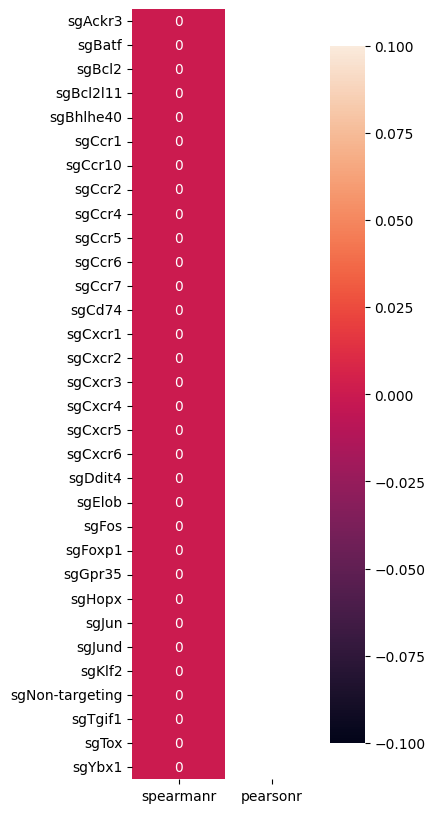

In [21]:
import seaborn as sns
plt.figure(figsize=(3, 10))
sns.heatmap(df.sort_values(by='spearmanr', ascending=False), annot=True)
plt.show()

In [22]:
from scipy.stats import f_oneway
r_dict = {}
for guide in guide_genes:
    r_dict[guide] = f_oneway(c_df[guide], c_df['sgNon-targeting'])[1]

In [23]:
df = pd.DataFrame(r_dict, index=['p']).T
df.sort_values(by='p', inplace=True)

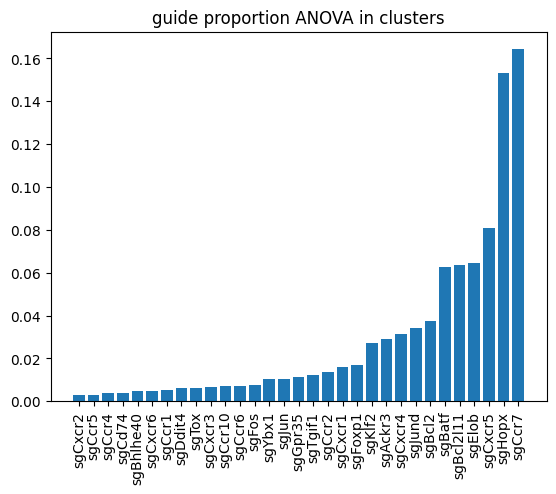

In [24]:
plt.bar(df[:-1].index, df[:-1].p)
plt.xticks(rotation=90)
plt.title("guide proportion ANOVA in clusters")
plt.show()

# permutation plot

In [25]:
from scipy.stats import chi2_contingency

for guide in gdata.var_names:
    data = np.array([c_df[guide].tolist(), c_df["sgNon-targeting"].tolist()])
    chi2, p, dof, expected = chi2_contingency(data)

    print(f"{guide}: P-value: {p}")

sgAckr3: P-value: 2.1445469244212224e-22
sgBatf: P-value: 3.062789861129381e-13
sgBcl2: P-value: 3.318998701201125e-24
sgBcl2l11: P-value: 2.5383224888147146e-25
sgBhlhe40: P-value: 9.143983802015028e-22
sgCcr1: P-value: 1.718909410716602e-06
sgCcr10: P-value: 4.8536620813624134e-18
sgCcr2: P-value: 8.113665994861626e-06
sgCcr4: P-value: 3.832791772771331e-08
sgCcr5: P-value: 2.688543424822327e-06
sgCcr6: P-value: 5.768568305621408e-12
sgCcr7: P-value: 2.0886060367873046e-20
sgCd74: P-value: 1.327777976718261e-30
sgCxcr1: P-value: 0.00034714409523358943
sgCxcr2: P-value: 9.392768935464616e-07
sgCxcr3: P-value: 1.1408766697602278e-24
sgCxcr4: P-value: 0.0026634810514666717
sgCxcr5: P-value: 3.008371738742688e-05
sgCxcr6: P-value: 1.1578658377701597e-08
sgDdit4: P-value: 1.3206167315747578e-11
sgElob: P-value: 4.064983974123651e-52
sgFos: P-value: 0.015631703488157907
sgFoxp1: P-value: 4.055580284393926e-13
sgGpr35: P-value: 6.51664530020538e-61
sgHopx: P-value: 3.7049019674661773e-29
sg

In [26]:
from scipy.stats import mannwhitneyu

guide = "sgCxcr3"

xdf = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=fdata.obs_names), pd.DataFrame(fdata.obs["cluster"])], axis=1)
guide_dict = {group: group_df[guide].tolist() for group, group_df in xdf.groupby('cluster')}
ntc_dict = {group: group_df["sgNon-targeting"].tolist() for group, group_df in xdf.groupby('cluster')}

categories = range(len(np.unique(fdata.obs["cluster"])))
# 对每个类别进行Mann-Whitney U检验
for category in categories:
    u_statistic, p_value = mannwhitneyu(guide_dict[category], ntc_dict[category])
    print(f"{category} - U Statistic: {u_statistic}, P-value: {p_value}")

0 - U Statistic: 246348.5, P-value: 6.0980165922108595e-06
1 - U Statistic: 474062.0, P-value: 1.3758332291108128e-08
2 - U Statistic: 1129485.5, P-value: 0.001307902282009435
3 - U Statistic: 436098.0, P-value: 1.40739642878193e-09
4 - U Statistic: 1108029.0, P-value: 1.0971536131521492e-12
5 - U Statistic: 730734.0, P-value: 2.9410080067095424e-11
6 - U Statistic: 1063433.5, P-value: 4.993088262970737e-08
7 - U Statistic: 231083.5, P-value: 6.609854068198867e-11
8 - U Statistic: 359488.0, P-value: 0.0001358574513069331
9 - U Statistic: 433810.5, P-value: 0.0009874435489145266
10 - U Statistic: 196771.5, P-value: 2.493946293407014e-10


/tmp/ipykernel_73714/3002380966.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  guide_dict = {group: group_df[guide].tolist() for group, group_df in xdf.groupby('cluster')}
/tmp/ipykernel_73714/3002380966.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ntc_dict = {group: group_df["sgNon-targeting"].tolist() for group, group_df in xdf.groupby('cluster')}


# MANOVA

In [28]:
import statsmodels.api as sm
import numpy as np

# Example data
data = np.random.poisson(lam=0.5, size=100)
data[np.random.rand(len(data)) < 0.5] = 0  # Introducing excess zeros

data = gdata[fdata.obs["cluster"] == 10][:, "sgYbx1"].X.toarray().flatten()

# Fit Zero-Inflated Poisson
model = sm.ZeroInflatedPoisson(data, np.ones(len(data)), inflation='logit').fit()
model.params

Optimization terminated successfully.
         Current function value: 0.207521
         Iterations: 13
         Function evaluations: 21
         Gradient evaluations: 21


array([3.47933838, 1.22664094])

In [ ]:
maov.mv_test().results["category"]["stat"]["Pr > F"].iloc[0]

0.5130550425950797

In [29]:
n_gdata = gdata.copy()

In [30]:
for i in range(len(n_gdata.var_names)):
    n_gdata.X[:, i] = n_gdata.X[:, i] / np.sum(n_gdata.X[:, i]) * 1e4

In [31]:
ntc_data = n_gdata[fdata.obs["cluster"] == 5][:, "sgNon-targeting"].X.toarray().flatten()
print(sm.ZeroInflatedPoisson(ntc_data, np.ones(len(ntc_data)), inflation='logit').fit(disp=False).summary())
print(sm.ZeroInflatedPoisson(ntc_data, np.ones(len(ntc_data)), inflation='logit').fit(disp=False).params)

guide_data = n_gdata[fdata.obs["cluster"] == 5][:, "sgBhlhe40"].X.toarray().flatten()
print(sm.ZeroInflatedPoisson(guide_data, np.ones(len(guide_data)), inflation='logit').fit(disp=False).summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 1252
Model:             ZeroInflatedPoisson   Df Residuals:                     1251
Method:                            MLE   Df Model:                            0
Date:                 Tue, 23 Jul 2024   Pseudo R-squ.:               7.567e-12
Time:                         07:50:12   Log-Likelihood:                -3872.6
converged:                        True   LL-Null:                       -3872.6
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     2.1640      0.093     23.277      0.000       1.982       2.346
const             3.0104      0.020    154.029      0.000       2.972       3.049
[2.16395208 3.01035323]
        

In [37]:
from statsmodels.multivariate.manova import MANOVA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=RuntimeWarning)

p_value = {}
f_value = {}

clusters = fdata.obs["cluster"].unique()
columns = ["ntc_pi", "ntc_lambda", "guide_pi", "guide_lambda", "category"]
for idx, guide in tqdm(enumerate(n_gdata.var_names)):
    if guide == "sgNon-targeting": continue
    param_df = pd.DataFrame(columns=columns)
    for idy, cluster in enumerate(clusters):
        ntc_data = n_gdata[fdata.obs["cluster"] == cluster][:, "sgNon-targeting"].X.toarray().flatten()
        ntc_model = sm.ZeroInflatedPoisson(ntc_data, np.ones(len(ntc_data)), inflation='logit').fit(disp=False)

        guide_data = n_gdata[fdata.obs["cluster"] == cluster][:, guide].X.toarray().flatten()
        guide_model = sm.ZeroInflatedPoisson(guide_data, np.ones(len(guide_data)), inflation='logit').fit(disp=False)
        df = pd.DataFrame([ntc_model.params[0], ntc_model.params[1], guide_model.params[0], guide_model.params[1], cluster]).T
        df.replace(-np.inf, -10, inplace=True)
        df.columns = columns
        param_df = pd.concat([param_df, df])
    param_df["category"] = param_df["category"].astype("int").astype("category").tolist()
    #print(guide, param_df)
    maov = MANOVA.from_formula('ntc_pi + ntc_lambda + guide_pi + guide_lambda ~ category', data=param_df)
    #print(param_df)
    #print(guide, maov.mv_test().results["category"]["stat"]["Pr > F"].iloc[0])
    p_value[guide] = maov.mv_test().results["category"]["stat"]["Pr > F"].iloc[0] 
    #f_value[guide] = maov.mv_test().results["category"]["stat"]["F Value"].iloc[0]
    f_value[guide] = maov.mv_test().results["Intercept"]["stat"]["Pr > F"].iloc[0]

0it [00:00, ?it/s]

4it [00:01,  2.58it/s]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1338: RuntimeWarning: divide by zero encountered in log
  params = [np.log(const)]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1301: RuntimeWarning: invalid value encountered in multiply
  + endog * XB
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/optimize/_optimize.py:835: RuntimeWarning: invalid value encountered in subtract
  if (np.max(np.ravel(np.abs(sim[1:] - sim[0]))) <= xatol and
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/optimize/_optimize.py:840: RuntimeWarning: invalid value encountered in subtract
  xr = (1 + rho) * xbar - rho * sim[-1]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/optimize/_optimize.py:890: RuntimeWarning: invalid value encountered in subtract
  sim[j] = sim[0] + sigma * (sim[j] - sim[0])
/home/wpy/miniconda3/en

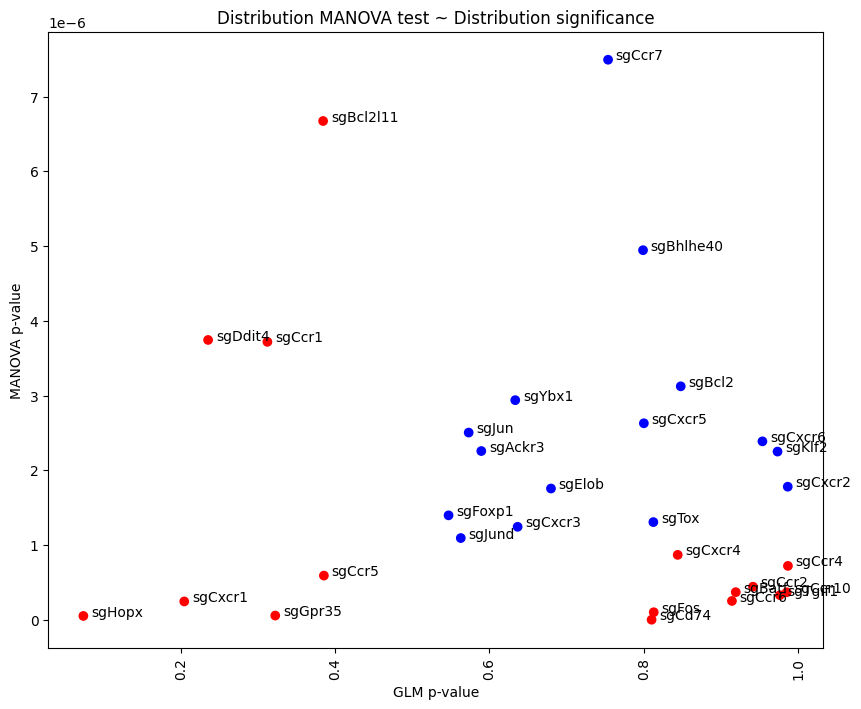

In [64]:
p_df = pd.concat([pd.DataFrame(p_value, index=['p']).T, pd.DataFrame(f_value, index=['f']).T], axis=1)
plt.figure(figsize=(10, 8))
colors = []
for idx in p_df.index:
    plt.text(p_df.loc[idx, 'p'] + 0.01, p_df.loc[idx, 'f'], f"{idx}", ha='left')
    colors.append('red' if ((p_df.loc[idx, 'f'] < 1e-6) or (p_df.loc[idx, 'p'] < 0.5)) else 'blue')
plt.scatter(p_df.p, p_df.f, c=colors)
plt.xticks(rotation=90)
plt.ylabel("MANOVA p-value")
plt.xlabel("GLM p-value")
plt.title("Distribution MANOVA test ~ Distribution significance")
plt.show()

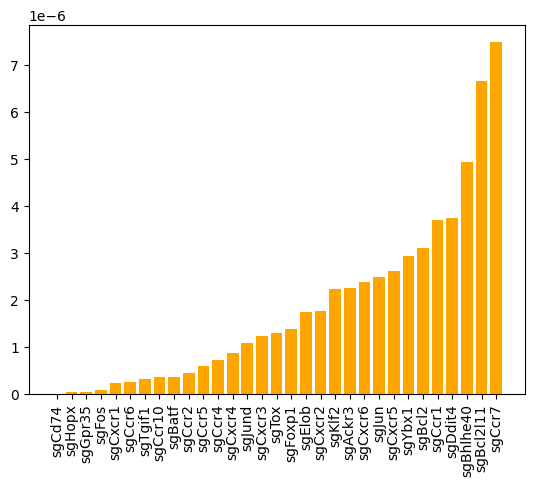

In [66]:
df = pd.DataFrame(p_df.loc[:, 'f'].tolist(), index=p_df.index).sort_values(by=0)
plt.bar(df.index, df[0], color='orange')
plt.xticks(rotation=90)
plt.show()

32it [00:02, 14.07it/s]


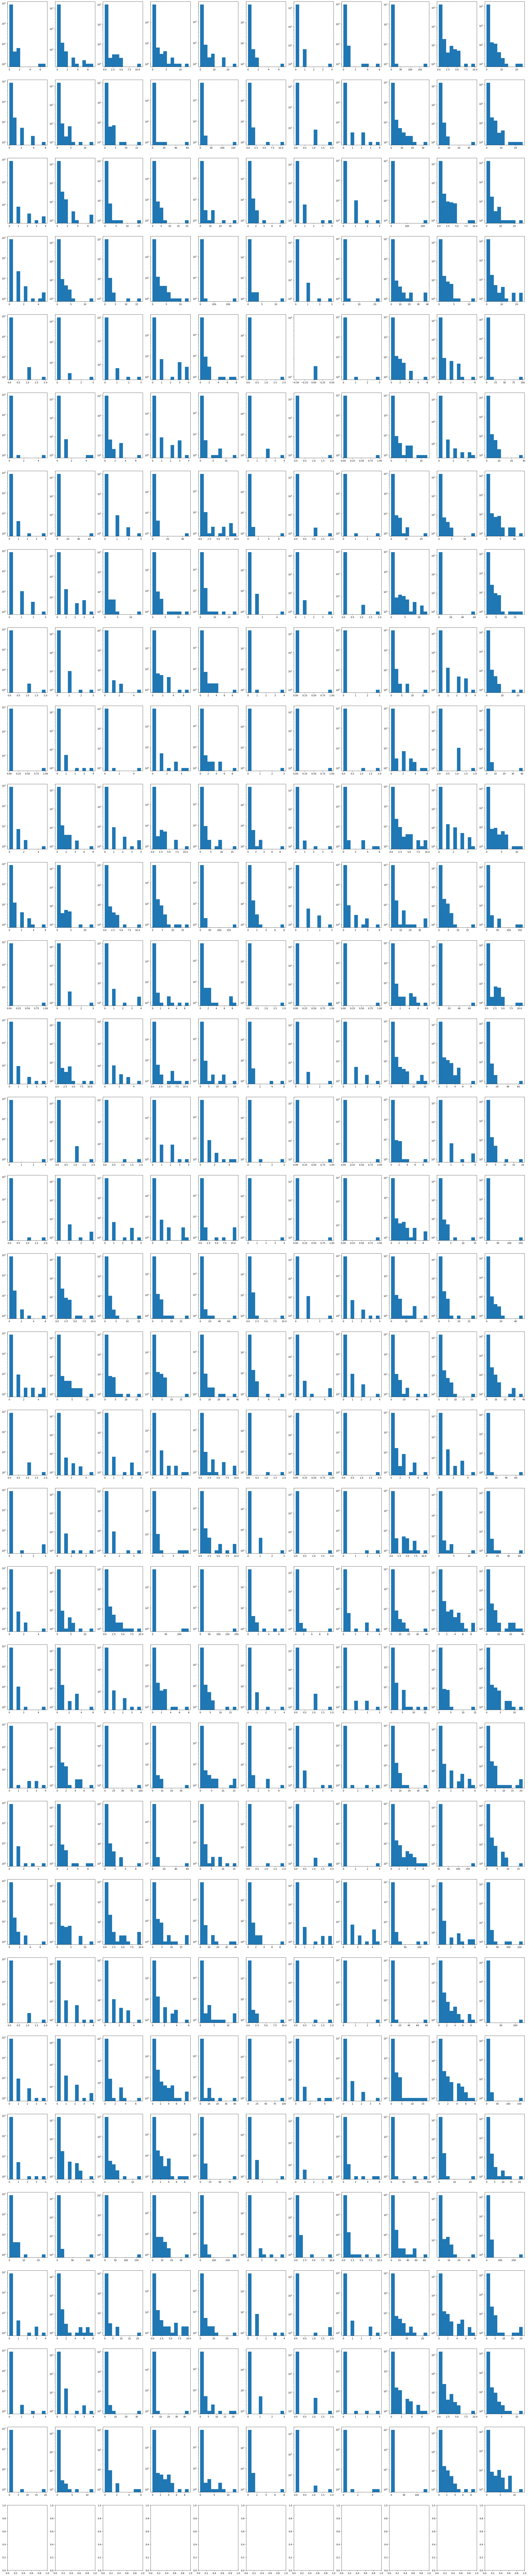

In [ ]:
# distribution of guide:
fig, axs = plt.subplots(33, 11, figsize=(40, 200))
clusters = fdata.obs["cluster"].unique()
for idx, guide in tqdm(enumerate(gdata.var_names)):
    for idy, cluster in enumerate(clusters):
        ax = axs[idx, idy]
        ax.hist(gdata[fdata.obs["cluster"] == cluster][:, guide].X.toarray().flatten())
        ax.set_yscale('log')